In [1]:
import os
kaggle_auth = {"username":"kaggleusername","key":"kagglekey"}
os.environ['KAGGLE_USERNAME'] = kaggle_auth["username"]
os.environ['KAGGLE_KEY'] = kaggle_auth["key"]
!kaggle datasets download preetviradiya/brian-tumor-dataset
!pip install timm
!pip install matplotlib
!pip install torcheval

 91% 98.0M/107M [00:01<00:00, 107MB/s]
100% 107M/107M [00:01<00:00, 107MB/s] 
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 2.0 MB/s eta 0:00:00


In [2]:
import timm
from fastcore.all import *
from fastai.vision.all import *

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import zipfile
from torcheval.metrics import MulticlassAccuracy, BinaryAUPRC, BinaryPrecision, BinaryRecall
import gc

In [3]:
with zipfile.ZipFile('brian-tumor-dataset.zip', 'r') as zip_ref:
  zip_ref.extractall()

In [17]:
# Constants
BATCH_SIZE = 64
NUM_OF_EPOCHS = 5
MODEL_NAME = "efficientnet_b0"
base_model_output_size = 1280
LEARNING_RATE = 0.001
DROPOUT_PROB = 0.3
DATASET_PATH = "Brain Tumor Data Set/Brain Tumor Data Set"
IMG_HEIGHT_WIDTH = 128

In [5]:
class BrainTumorDataset(Dataset):
  def __init__(self, data_directory, transform=None):
    self.data = ImageFolder(data_directory, transform=transform)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    return self.data[index]

  @property
  def classes(self):
    return self.data.classes

In [6]:
transform = transforms.Compose([transforms.Resize((IMG_HEIGHT_WIDTH, IMG_HEIGHT_WIDTH)), transforms.ToTensor()])

dataset = BrainTumorDataset(Path(DATASET_PATH), transform)

indexes_to_classes = {v: k for k, v in ImageFolder(Path(DATASET_PATH)).class_to_idx.items()}

for image, label in dataset:
  break

image.shape # [image_dimensions, image_height, image_width]

torch.Size([3, 128, 128])

In [7]:
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

for images, labels in dataloader:
  break

images.shape, labels.shape # [batch_size, image_dimensions, image_height, image_width]

(torch.Size([64, 3, 128, 128]), torch.Size([64]))

In [8]:
class BrainTumorClassifierPreTrainedFineTunedCNN(nn.Module):
  def __init__(self, number_of_classes):
    super(BrainTumorClassifierPreTrainedFineTunedCNN, self).__init__()

    # Where we define all the parts of the model
    self.base_model = timm.create_model(MODEL_NAME, pretrained=True, num_classes=0)

    # making our last layer (the classifier)
    self.classifier =  nn.Sequential(nn.Dropout(p=DROPOUT_PROB), nn.Linear(base_model_output_size, number_of_classes))

  def forward(self, x):
    # Connect these parts and return the output
    x = self.base_model(x)
    output = self.classifier(x)
    return output

In [9]:
class BrainTumorClassifierNotPreTrainedFineTunedCNN(nn.Module):
  def __init__(self, number_of_classes):
    super(BrainTumorClassifierNotPreTrainedFineTunedCNN, self).__init__()

    # Where we define all the parts of the model
    self.base_model = timm.create_model(MODEL_NAME, pretrained=False, num_classes=0)

    # making our last layer (the classifier)
    self.classifier =  nn.Sequential(nn.Dropout(p=DROPOUT_PROB), nn.Linear(base_model_output_size, number_of_classes))

  def forward(self, x):
    # Connect these parts and return the output
    x = self.base_model(x)
    output = self.classifier(x)
    return output

In [10]:
class BrainTumorClassifierCNN(nn.Module):
  def __init__(self, number_of_classes):
    super(BrainTumorClassifierCNN, self).__init__()

    self.layer1 = nn.Conv2d(3, 8, stride=2, kernel_size=3)
    self.layer1_norm = nn.BatchNorm2d(8)
    self.layer1_activation = nn.ReLU()

    self.layer2 = nn.Conv2d(8, 16, stride=2, kernel_size=3)
    self.layer2_norm = nn.BatchNorm2d(16)
    self.layer2_activation = nn.ReLU()

    self.layer3 = nn.Conv2d(16, 32, stride=2, kernel_size=3)
    self.layer3_norm = nn.BatchNorm2d(32)
    self.layer3_activation = nn.ReLU()

    self.layer4 = nn.Conv2d(32, 2, stride=2, kernel_size=3)
    self.layer5 = nn.Flatten()

  def forward(self, x):
    # Connect these parts and return the output
    layer1_output = self.layer1_activation(self.layer1_norm(self.layer1(x)))
    layer2_output = self.layer2_activation(self.layer2_norm(self.layer2(layer1_output)))
    layer3_output = self.layer3_activation(self.layer3_norm(self.layer3(layer2_output)))
    layer4_output = self.layer4(layer3_output)
    output = self.layer5(layer4_output)
    return output

In [11]:
class BrainTumorClassifierMLP(nn.Module):
  def __init__(self, number_of_classes):
    super(BrainTumorClassifierMLP, self).__init__()
    inital_input_size = 3 * IMG_HEIGHT_WIDTH * IMG_HEIGHT_WIDTH
    inital_output_size = IMG_HEIGHT_WIDTH // 3
    self.first_linear = nn.Linear(inital_input_size, inital_output_size)
    self.first_layer_activation = nn.ReLU()
    self.second_linear = nn.Linear(inital_output_size, inital_output_size//4)
    self.second_layer_activation = nn.ReLU()
    self.third_linear = nn.Linear(inital_output_size//4, inital_output_size//8)
    self.third_layer_activation = nn.ReLU()
    self.fourth_linear = nn.Linear(inital_output_size//8, number_of_classes)

  def forward(self, x):
    # Connect the parts and return the output
    x = x.view(x.size(0), -1)
    first_layer = self.first_linear(x)
    first_activation = self.first_layer_activation(first_layer)
    second_layer = self.second_linear(first_activation)
    second_activation = self.second_layer_activation(second_layer)
    third_layer = self.third_linear(second_activation)
    third_activation = self.third_layer_activation(third_layer)
    output = self.fourth_linear(third_activation)
    return output

In [12]:
class BrainTumorClassifierLinearRegression(nn.Module):
  def __init__(self, number_of_classes):
    super(BrainTumorClassifierLinearRegression, self).__init__()

    self.linear =  nn.Linear((3 * IMG_HEIGHT_WIDTH * IMG_HEIGHT_WIDTH), number_of_classes)

  def forward(self, x):
    # Connect the parts and return the output
    x = x.view(x.size(0), -1)
    output = self.linear(x)
    return output

In [ ]:
models = [BrainTumorClassifierPreTrainedFineTunedCNN(len(indexes_to_classes)), BrainTumorClassifierNotPreTrainedFineTunedCNN(len(indexes_to_classes)), BrainTumorClassifierCNN(len(indexes_to_classes)), BrainTumorClassifierMLP(len(indexes_to_classes)), BrainTumorClassifierLinearRegression(len(indexes_to_classes))]

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Start trainging model: BrainTumorClassifierPreTrainedFineTunedCNN
Base line loss: 0.675, accuracy: 0.5333333611488342, precision: 0.43617022037506104, recall: 0.06487341970205307, auprc: 0.4565567076206207
Epoch 1/5 - Train loss: 0.160, Validation loss: 0.089
Train acc - 0.9350931644439697, valid acc - 0.9753623008728027
auprc - 0.9645264744758606, precision - 0.9853895902633667, recall - 0.9604430198669434
Epoch 2/5 - Train loss: 0.040, Validation loss: 0.073
Train acc - 0.9881987571716309, valid acc - 0.9818840622901917
auprc - 0.9682483077049255, precision - 0.976452112197876, recall - 0.9841772317886353
Epoch 3/5 - Train loss: 0.035, Validation loss: 0.072
Train acc - 0.9888198971748352, valid acc - 0.9818840622901917
auprc - 0.9637932777404785, precision - 0.9662058353424072, recall - 0.9952531456947327
Epoch 4/5 - Train loss: 0.027, Validation loss: 0.052
Train acc - 0.9909937977790833, valid acc - 0.9884058237075806
auprc - 0.982717752456665, precision - 0.9920127987861633, reca

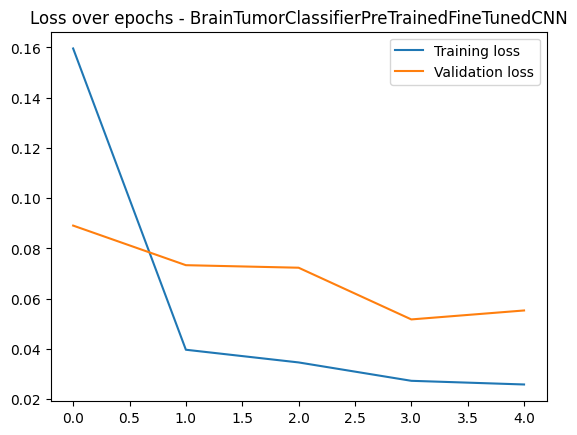




Start trainging model: BrainTumorClassifierNotPreTrainedFineTunedCNN
Base line loss: 0.695, accuracy: 0.4528985619544983, precision: 0.4528985619544983, recall: 1.0, auprc: 0.4528985619544983
Epoch 1/5 - Train loss: 0.572, Validation loss: 0.483
Train acc - 0.716149091720581, valid acc - 0.7942029237747192
auprc - 0.7100062966346741, precision - 0.822306215763092, recall - 0.6959999799728394
Epoch 2/5 - Train loss: 0.186, Validation loss: 0.289
Train acc - 0.9310559034347534, valid acc - 0.895652174949646
auprc - 0.8404923677444458, precision - 0.9015024900436401, recall - 0.8640000224113464
Epoch 3/5 - Train loss: 0.059, Validation loss: 0.311
Train acc - 0.9822981357574463, valid acc - 0.9021739363670349
auprc - 0.8392310738563538, precision - 0.8757668733596802, recall - 0.9136000275611877
Epoch 4/5 - Train loss: 0.033, Validation loss: 0.270
Train acc - 0.989130437374115, valid acc - 0.9326087236404419
auprc - 0.8953942656517029, precision - 0.9389439225196838, recall - 0.910399

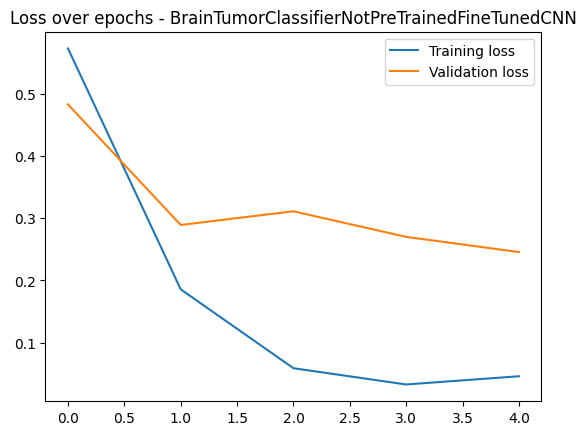




Start trainging model: BrainTumorClassifierCNN
Base line loss: 4.616, accuracy: 0.0, precision: 0.4753623306751251, recall: 1.0, auprc: 0.47523799538612366
Epoch 1/5 - Train loss: 2.154, Validation loss: 1.723
Train acc - 0.4549689292907715, valid acc - 0.519565224647522
auprc - 0.4971585273742676, precision - 0.5314136147499084, recall - 0.6189024448394775
Epoch 2/5 - Train loss: 1.295, Validation loss: 1.205
Train acc - 0.5531055927276611, valid acc - 0.5644927620887756
auprc - 0.5190480947494507, precision - 0.5780998468399048, recall - 0.5472561120986938
Epoch 3/5 - Train loss: 1.062, Validation loss: 1.043
Train acc - 0.5987577438354492, valid acc - 0.6188405752182007
auprc - 0.5656375885009766, precision - 0.6233766078948975, recall - 0.6585366129875183
Epoch 4/5 - Train loss: 0.923, Validation loss: 1.002
Train acc - 0.6546583771705627, valid acc - 0.6355072259902954
auprc - 0.5693044066429138, precision - 0.651199996471405, recall - 0.6204268336296082
Epoch 5/5 - Train loss:

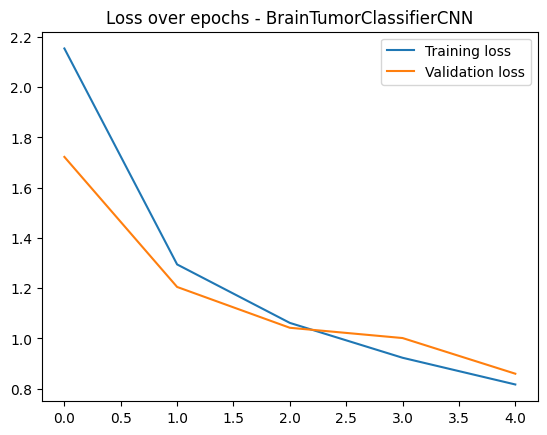




Start trainging model: BrainTumorClassifierMLP
Base line loss: 0.691, accuracy: 0.5471014380455017, precision: 0.0, recall: 0.0, auprc: 0.4528985619544983
Epoch 1/5 - Train loss: 0.686, Validation loss: 0.598
Train acc - 0.5916149020195007, valid acc - 0.6847826242446899
auprc - 0.5829567909240723, precision - 0.6384839415550232, recall - 0.7008000016212463
Epoch 2/5 - Train loss: 0.558, Validation loss: 0.501
Train acc - 0.70652174949646, valid acc - 0.7681159377098083
auprc - 0.6735395789146423, precision - 0.769911527633667, recall - 0.6959999799728394
Epoch 3/5 - Train loss: 0.494, Validation loss: 0.476
Train acc - 0.7708074450492859, valid acc - 0.7855072617530823
auprc - 0.7238610982894897, precision - 0.9272727370262146, recall - 0.5712000131607056
Epoch 4/5 - Train loss: 0.414, Validation loss: 0.498
Train acc - 0.8282608985900879, valid acc - 0.7550724744796753
auprc - 0.6490651965141296, precision - 0.6610549688339233, recall - 0.9423999786376953
Epoch 5/5 - Train loss: 0

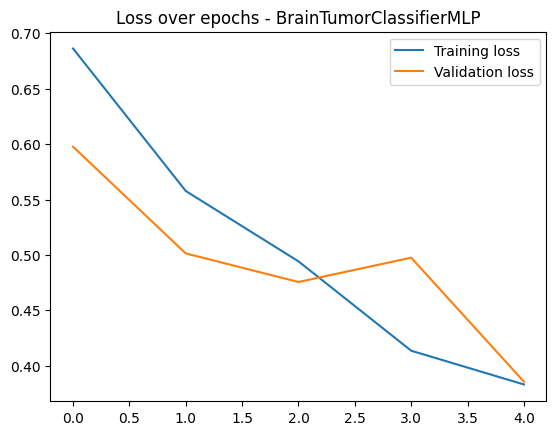




Start trainging model: BrainTumorClassifierLinearRegression
Base line loss: 0.709, accuracy: 0.4384058117866516, precision: 0.4109589159488678, recall: 0.4651162922382355, auprc: 0.4411436915397644
Epoch 1/5 - Train loss: 1.012, Validation loss: 0.689
Train acc - 0.6757764220237732, valid acc - 0.6637681126594543
auprc - 0.5805800557136536, precision - 0.587270975112915, recall - 0.9441860318183899
Epoch 2/5 - Train loss: 0.579, Validation loss: 0.456
Train acc - 0.7627329230308533, valid acc - 0.800000011920929
auprc - 0.7084612846374512, precision - 0.7430830001831055, recall - 0.8744186162948608
Epoch 3/5 - Train loss: 0.572, Validation loss: 0.411
Train acc - 0.7689440846443176, valid acc - 0.843478262424469
auprc - 0.7816080451011658, precision - 0.8679245114326477, recall - 0.7844961285591125
Epoch 4/5 - Train loss: 0.404, Validation loss: 0.491
Train acc - 0.8276397585868835, valid acc - 0.8101449012756348
auprc - 0.7645379304885864, precision - 0.9303370714187622, recall - 0

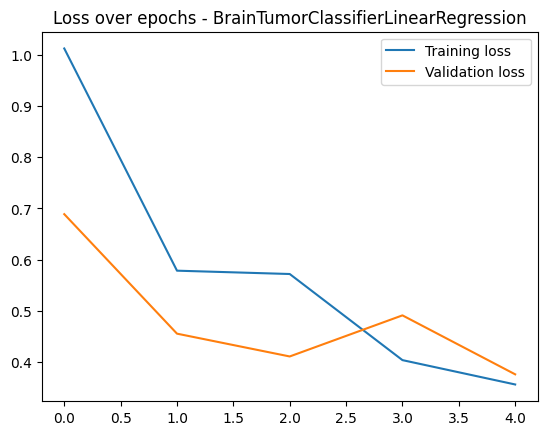

In [15]:

for model in models:
  print(f"Start trainging model: {type(model).__name__}")

  # Loss function
  loss_function = nn.CrossEntropyLoss()

  # Optimizer
  optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

  # Creating training and validation dataloaders
  training_set_length = (int) (len(dataset) * 0.7)
  validation_set_length = len(dataset) - training_set_length

  training_set, validation_set = torch.utils.data.random_split(dataset, [training_set_length, validation_set_length])

  training_loader = DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True)
  validation_loader = DataLoader(validation_set, batch_size=BATCH_SIZE, shuffle=False)
  test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

  train_losses, val_losses = [], []

  model.to(device)

  # Baseline of the model:

  base_line_loss = []
  base_line_metric = MulticlassAccuracy()
  base_line_auprc = BinaryAUPRC()
  base_line_precision = BinaryPrecision()
  base_line_recall = BinaryRecall()

  model.eval()
  base_line_running_loss = 0.0
  with torch.no_grad():
    for images, labels in validation_loader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      loss = loss_function(outputs, labels)
      base_line_metric.update(outputs.argmax(1), labels)
      base_line_auprc.update(outputs.argmax(1), labels)
      base_line_precision.update(outputs.argmax(1), labels)
      base_line_recall.update(outputs.argmax(1), labels)
      base_line_running_loss += loss.item() * images.size(0)

  base_line_loss = base_line_running_loss / len(validation_loader.dataset)

  print(f"Base line loss: {base_line_loss:.3f}, accuracy: {base_line_metric.compute()}, precision: {base_line_precision.compute()}, recall: {base_line_recall.compute()}, auprc: {base_line_auprc.compute()}")

  # Training Loop
  for epoch in range(NUM_OF_EPOCHS):
    # Set the model to train
    model.train()
    train_metric = MulticlassAccuracy()
    valid_metric = MulticlassAccuracy()
    auprc = BinaryAUPRC()
    precision = BinaryPrecision()
    recall = BinaryRecall()

    running_loss = 0.0
    for images, labels in training_loader:
      images, labels = images.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(images)
      loss = loss_function(outputs, labels)
      train_metric.update(outputs.argmax(1), labels)
      loss.backward()
      optimizer.step()
      # print(f"loss.item()={loss.item()}, images.size(0)={images.size(0)}")
      running_loss += loss.item() * images.size(0)

    train_loss = running_loss / len(training_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase in the epoch
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in validation_loader:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          loss = loss_function(outputs, labels)
          valid_metric.update(outputs.argmax(1), labels)
          auprc.update(outputs.argmax(1), labels)
          precision.update(outputs.argmax(1), labels)
          recall.update(outputs.argmax(1), labels)
          running_loss += loss.item() * images.size(0)

    validation_loss = running_loss / len(validation_loader.dataset)
    val_losses.append(validation_loss)

    # Print epoch stats
    print(f"Epoch {epoch+1}/{NUM_OF_EPOCHS} - Train loss: {train_loss:.3f}, Validation loss: {validation_loss:.3f}")
    print(f"Train acc - {train_metric.compute()}, valid acc - {valid_metric.compute()}")
    print(f"auprc - {auprc.compute()}, precision - {precision.compute()}, recall - {recall.compute()}")

  plt.plot(train_losses, label='Training loss')
  plt.plot(val_losses, label='Validation loss')
  plt.legend()
  plt.title(f"Loss over epochs - {type(model).__name__}")
  plt.show()

  torch.cuda.empty_cache()
  gc.collect()
  print("\n\n")